# Phishing Detection using Machine Learning

## Import

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Loading Dataset

Dataset found on Kaggle: https://www.kaggle.com/datasets/shashwatwork/phishing-dataset-for-machine-learning/data

From the paper: Tan, Choon Lin (2018), “Phishing Dataset for Machine Learning: Feature Evaluation”, Mendeley Data, V1, doi: 10.17632/h3cgnj8hft.1

In [9]:
!kaggle datasets download -d shashwatwork/phishing-dataset-for-machine-learning

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/phishing-dataset-for-machine-learning
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/234k [00:00<?, ?B/s]
100% 234k/234k [00:00<00:00, 65.3MB/s]


In [10]:
import zipfile

with zipfile.ZipFile("phishing-dataset-for-machine-learning.zip", "r") as zip_ref:
    zip_ref.extractall("dataset")

# List extracted files
os.listdir("dataset")

['dataset.csv', 'Phishing_Legitimate_full.csv']

In [12]:
df = pd.read_csv("dataset/Phishing_Legitimate_full.csv")
df.head()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,4,3,1,6,79,1,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,5,3,0,4,46,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


## Data Analysis

This dataset contains 48 features extracted from 5000 phishing webpages and 5000 legitimate webpages, which were downloaded from January to May 2015 and from May to June 2017. An improved feature extraction technique is employed by leveraging the browser automation framework (i.e., Selenium WebDriver), which is more precise and robust compared to the parsing approach based on regular expressions.

Anti-phishing researchers and experts may find this dataset useful for phishing features analysis, conducting rapid proof of concept experiments or benchmarking phishing classification models.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

In [14]:
df.describe()

,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,...,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2.445100,0.586800,3.300300,70.264100,1.818000,0.138900,0.000300,0.013100,0.32320,...,0.339600,0.03220,0.030400,0.956600,0.020200,0.353300,0.793200,0.173400,0.314100,0.500000
std,2886.89568,1.346836,0.751214,1.863241,33.369877,3.106258,0.545744,0.017319,0.113709,1.11466,...,0.473597,0.17654,0.171694,0.248037,0.820036,0.888908,0.521019,0.755771,0.897843,0.500025
min,1.00000,1.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,2500.75000,2.000000,0.000000,2.000000,48.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000,-1.000000,0.000000
50%,5000.50000,2.000000,1.000000,3.000000,62.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.500000
75%,7500.25000,3.000000,1.000000,4.000000,84.000000,2.000000,0.000000,0.000000,0.000000,0.00000,...,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10000.00000,21.000000,14.000000,18.000000,253.000000,55.000000,9.000000,1.000000,1.000000,18.00000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
df.isnull().sum() # No null values

,0
id,0
NumDots,0
SubdomainLevel,0
PathLevel,0
UrlLength,0
NumDash,0
NumDashInHostname,0
AtSymbol,0
TildeSymbol,0
NumUnderscore,0


In [16]:
print(df.columns)

Index(['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash',
       'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore',
       'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash',
       'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress',
       'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname',
       'HostnameLength', 'PathLength', 'QueryLength', 'DoubleSlashInPath',
       'NumSensitiveWords', 'EmbeddedBrandName', 'PctExtHyperlinks',
       'PctExtResourceUrls', 'ExtFavicon', 'InsecureForms',
       'RelativeFormAction', 'ExtFormAction', 'AbnormalFormAction',
       'PctNullSelfRedirectHyperlinks', 'FrequentDomainNameMismatch',
       'FakeLinkInStatusBar', 'RightClickDisabled', 'PopUpWindow',
       'SubmitInfoToEmail', 'IframeOrFrame', 'MissingTitle',
       'ImagesOnlyInForm', 'SubdomainLevelRT', 'UrlLengthRT',
       'PctExtResourceUrlsRT', 'AbnormalExtFormActionR', 'ExtMetaScriptLinkRT',
       'PctExtNullSelfRedirectHyperl

Meaning of the feature columns:

- AtSymbol:  Boolean: Total number of '@' symbol in the URL.
- NumPercent: Total number of percent symbol present in the URL.
- NumQueryComponents: Total number of query components.
- NumAmpersand: Total number of '&' character.
- NumHash: Total number of '#' character.
- NumNumericChars: The total number of numeric characters.
- NoHttps: Boolean: Check if there is a HTTPS in the URL.
- RandomString: Boolean: Check if there is a set of Characters that are random.
- IPAddress: Check if the hostname of the URL uses the IP address.
- DomainsInSubDomains: Boolean: Determines if TLD or CCTLD is in the subdomain of URL.
- DomainsInPaths: Boolean: Determines if the website link has used TLD or CCTLD.
- HttpsInHostname: Boolean: Determines if HTTPS is disorderly in the hostname of the URL.
- DoubleSlashInPath: Boolean: Checks if there is a double slash in the path.
- NumSensitiveWords: Checks if there are any sensitive words like secure, sign in, login, etc.
- EmbeddedBrandName: Boolean: Checks if there is the name of a brand in the domain.
- PctExtHyperLinks Float Checks the percentage of external hyperlinks in the source code.

In [17]:
print(df['NoHttps'].unique())
print(df['CLASS_LABEL'].unique())
print(df['RandomString'].unique())
print(df['PctExtHyperlinks'].unique())
print(df['PctExtResourceUrls'].unique())

[1 0]
[1 0]
[0 1]
[0.         0.375      1.         ... 0.14965986 0.02688172 0.08962264]
[0.25       0.         1.         ... 0.18348624 0.1443299  0.75714286]


In [18]:
def corr_heatmap(data, idx_s, idx_e):
    y = data['CLASS_LABEL']
    temp = data.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['labels'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')


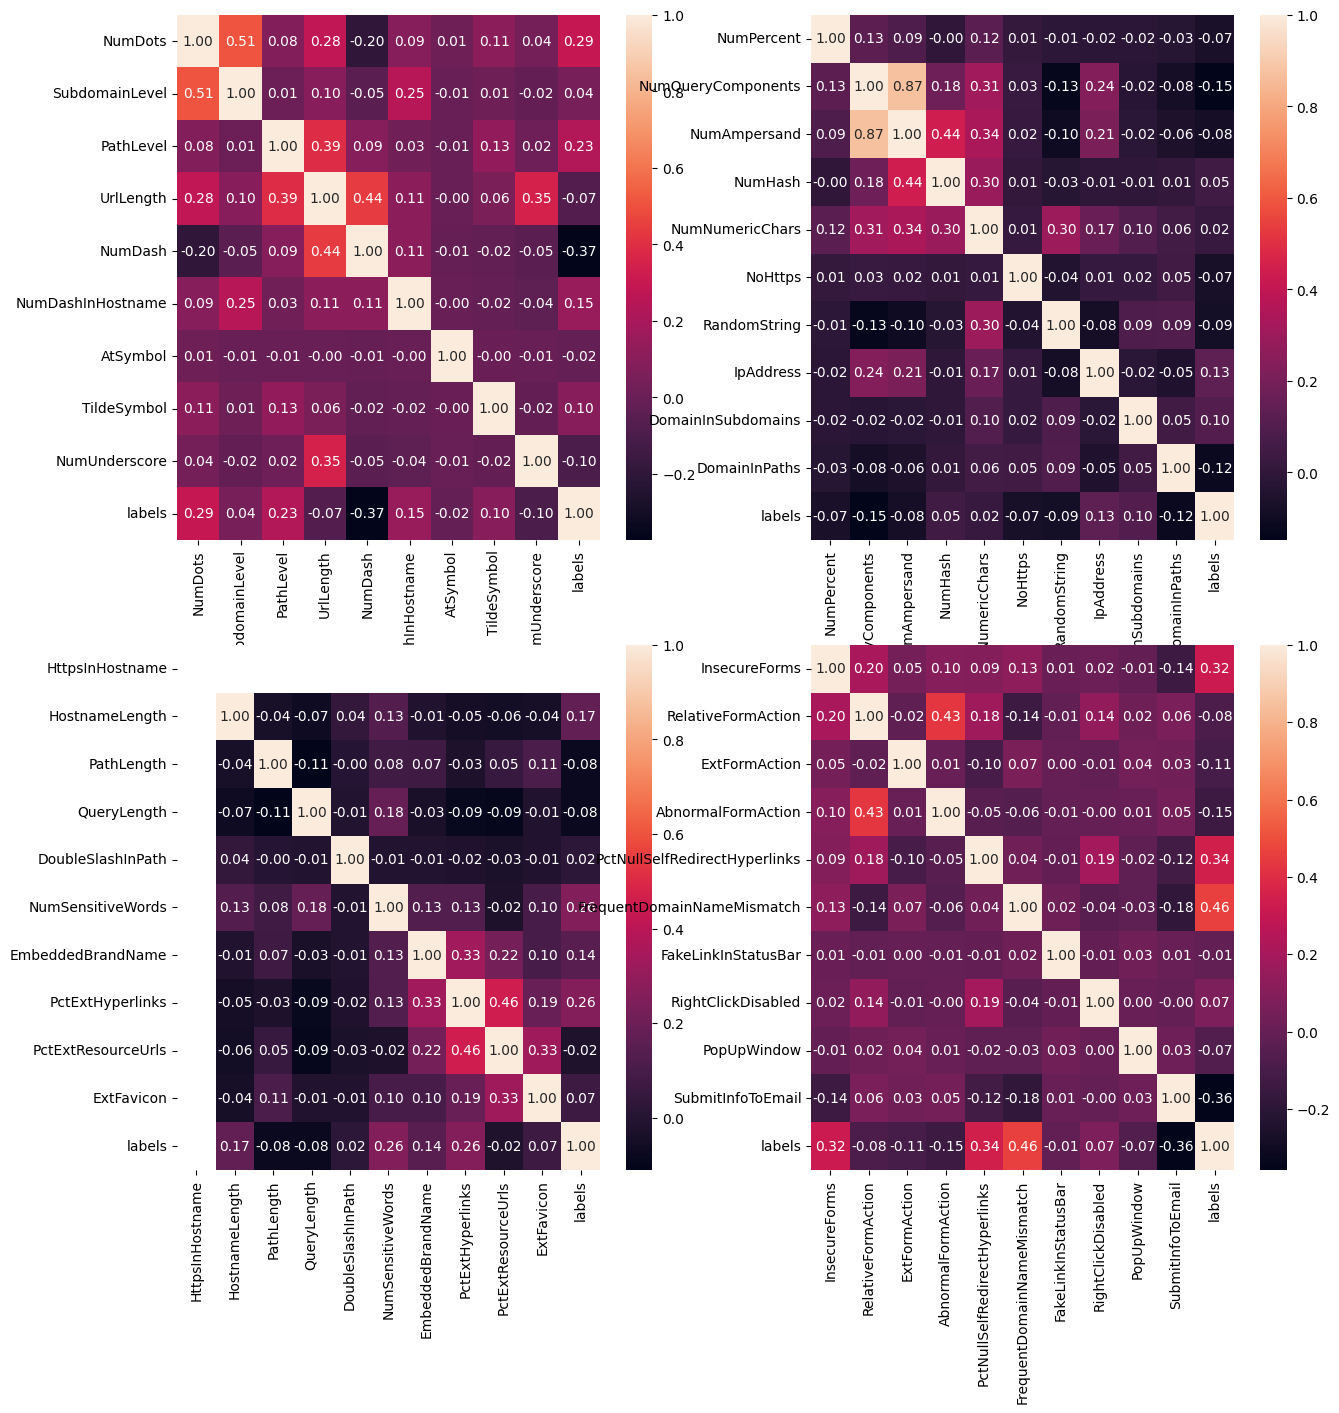

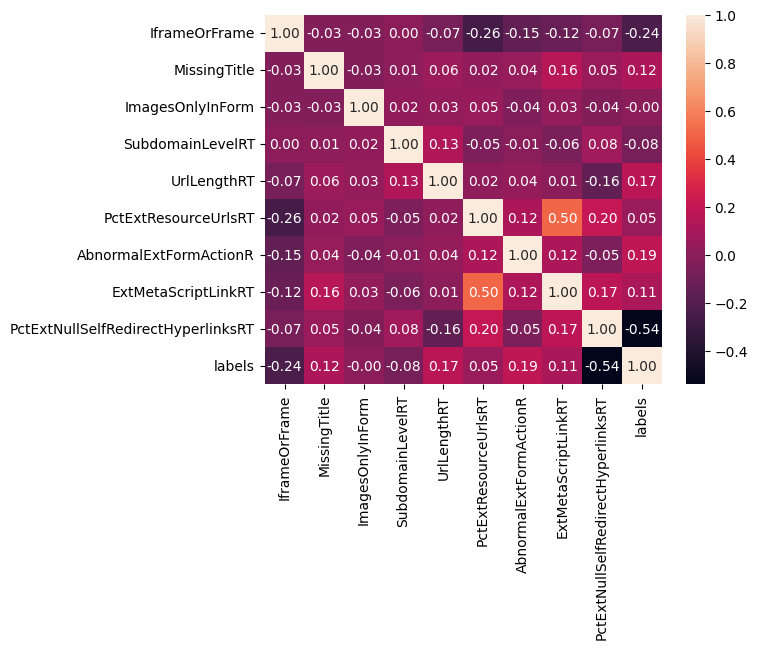

In [19]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
corr_heatmap(df, 0, 10)

plt.subplot(2, 2, 2)
corr_heatmap(df, 10, 20)

plt.subplot(2, 2, 3)
corr_heatmap(df, 20, 30)

plt.subplot(2, 2, 4)
corr_heatmap(df, 30, 40)

plt.show()

corr_heatmap(df, 40, 49)
plt.show()

Some features are highly correlated to one another:
- ExtMetaScriptLinkRT / PctExtResourceUrlsRT: 0.50
- labels / PctExtNUllSelfRedirectHyperlinksRT:-0.54
- PctExtResourceUrls / PctExttHyperlinks: 0.46
- RelativeFormAction / AbnormalFormAction: 0.43
- Labels / FrequentDomainNameMismatch: 0.46
- NumAmperSand / NumQueryComponents: 0.87
- NumHash / NumAmperSand: 0.44
- NUmDots / SubDomainLevel:0.51
- NumDash / UrlLength: 0.44
- UrlLength / PathLevel: 0.39
- NUmDash / Lables: -0.37


A lot of deatures + some seems highly correlated --> need to drop some features

Balanced dataset

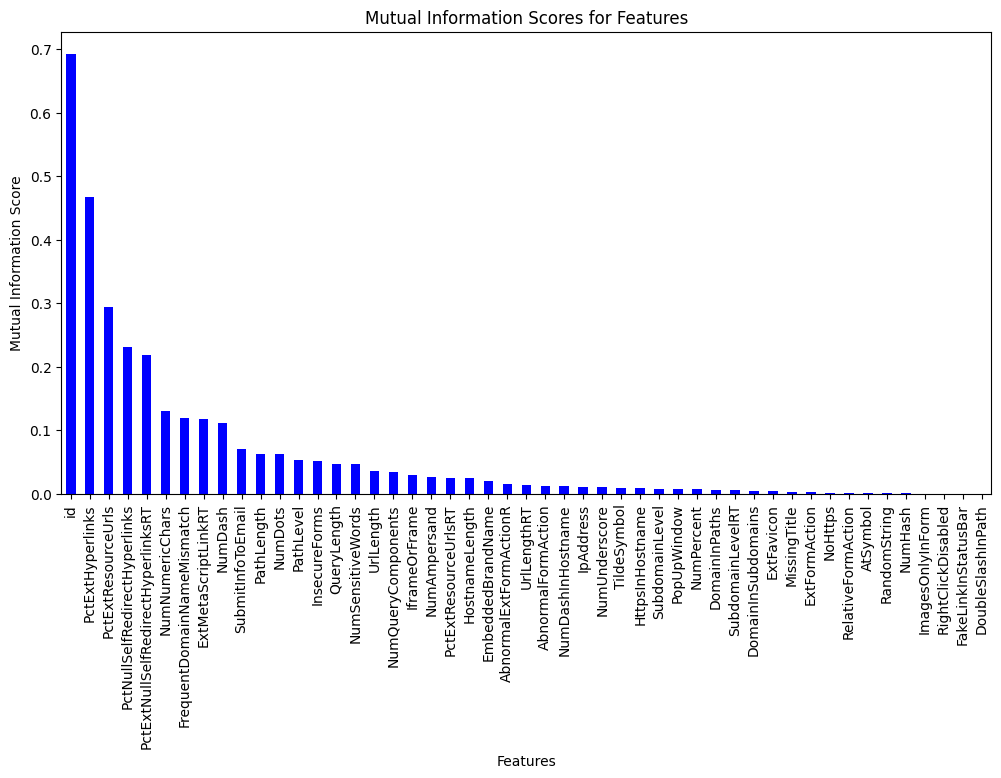

In [20]:
# Dropping features

#Let's compute the Mutual Information
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import matplotlib.pyplot as plt

X = df.drop(columns=['CLASS_LABEL'])
y = df['CLASS_LABEL']

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Plot Mutual Information scores
plt.figure(figsize=(12, 6))
mi_scores.plot(kind="bar", color="blue")
plt.title("Mutual Information Scores for Features")
plt.xlabel("Features")
plt.ylabel("Mutual Information Score")
plt.xticks(rotation=90)
plt.show()


MI measures how much each feature contributes to the target.
NumAmperSand has a lower MI score than NumQueryComponents --> Drop it❌

Some columns have close to zero mutual informations --> Their contribution to the model decisions is very small.

In [21]:
# Print very small MI scored features:
low_mi_features = mi_scores[mi_scores < 0.01].index
print(low_mi_features)


Index(['TildeSymbol', 'HttpsInHostname', 'SubdomainLevel', 'PopUpWindow',
       'NumPercent', 'DomainInPaths', 'SubdomainLevelRT', 'DomainInSubdomains',
       'ExtFavicon', 'MissingTitle', 'ExtFormAction', 'NoHttps',
       'RelativeFormAction', 'AtSymbol', 'RandomString', 'NumHash',
       'ImagesOnlyInForm', 'RightClickDisabled', 'FakeLinkInStatusBar',
       'DoubleSlashInPath'],
      dtype='object')


- 'AbnormalFormAction' ==> also correlated with Relative form action ✅
- 'ExtFormAction'
- 'NumUnderscore',
- 'EmbeddedBrandName'
- 'SubdomainLevel' ==> correlated with NumDots + lower MI score ==> Drop ❌
- 'RelativeFormAction' ==> also related to Abnormal form action + lower MI ==> Drop ❌
- 'RandomString'
- 'DomainInPaths'
- 'MissingTitle'
- 'HttpsInHostname' ==> relevant in a phishing context ✅
- 'SubdomainLevelRT'
- 'IpAddress'
- 'TildeSymbol'
- 'PopUpWindow' ==> relevant as pop-up windows relates to a malicious behavior ✅
- 'NumPercent'
- 'ExtFavicon'
- 'FakeLinkInStatusBar' ==> Seems relevant in a phishing context ✅
- 'RightClickDisabled',
- 'NumHash' ==> correlated whith NumAmperSand + lower MI score ==> Drop ❌
- 'ImagesOnlyInForm'
- 'NoHttps' ==> very important for phishing ✅
- 'AtSymbol'
- 'DoubleSlashInPath'

In [22]:
# Dropping feautures
df =df.drop(columns=['NumHash', 'SubdomainLevel', 'RelativeFormAction', 'NumQueryComponents'])

In [23]:
df.shape

(10000, 46)

In [24]:
# Let's analyse futher the low MI score features with a Random Forest
# Low feature Importance scores means the feature contributes little to decision making
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

X = df.drop(columns=["CLASS_LABEL"])
y = df["CLASS_LABEL"]

model = RandomForestClassifier()
model.fit(X, y)

feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

low_mi_features = ["ExtFormAction", "NumUnderscore", "EmbeddedBrandName", "RandomString",
                   "DomainInPaths", "MissingTitle", "SubdomainLevelRT", "IpAddress",
                   "TildeSymbol", "NumPercent", "ExtFavicon", "RightClickDisabled",
                   "ImagesOnlyInForm", "AtSymbol", "DoubleSlashInPath"]

print(feature_importance[low_mi_features].sort_values())


AtSymbol              0.000025
DoubleSlashInPath     0.000050
TildeSymbol           0.000069
ImagesOnlyInForm      0.000205
SubdomainLevelRT      0.000368
MissingTitle          0.000524
ExtFormAction         0.000537
RandomString          0.000852
NumPercent            0.000955
RightClickDisabled    0.000982
EmbeddedBrandName     0.001095
DomainInPaths         0.001121
IpAddress             0.001657
NumUnderscore         0.002084
ExtFavicon            0.003761
dtype: float64


Features having "MI score" < 0.01 and "feature importance score" < 0.005 will be dropped = all of the list.

In [25]:
df = df.drop(columns=low_mi_features)

In [26]:
df = df.drop(columns=['id'])

In [27]:
df.shape

(10000, 30)

As the dataset is balanced and of medium size, we will investigate on the performance of a Random Forest Classifier and XGBoost.
Why ? They can handle Non colinear data and can handle high dimensional datasets.

SVM would me more computationally expensive and requires a careful choice of kernel, would require a futher reduction of the dataste to be more efficient.

We will take a Decision Tree classifier as a baseline for this study.

The dataset being balanced, the accuracy will be chosen as the metric.

In [28]:
# Train/test split
X = df.drop(columns=["CLASS_LABEL"])
y = df["CLASS_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train

,NumDots,PathLevel,UrlLength,NumDash,NumDashInHostname,NumAmpersand,NumNumericChars,NoHttps,DomainInSubdomains,HttpsInHostname,...,FrequentDomainNameMismatch,FakeLinkInStatusBar,PopUpWindow,SubmitInfoToEmail,IframeOrFrame,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT
9254,2,2,41,0,0,0,4,1,0,0,...,0,0,0,0,0,1,1,0,1,0
1561,3,3,40,0,0,0,3,1,0,0,...,1,0,0,0,0,1,-1,1,-1,1
1670,3,4,53,0,0,0,6,1,0,0,...,0,0,0,0,0,1,1,1,0,-1
6087,3,2,89,12,0,0,14,1,0,0,...,0,0,0,1,0,-1,1,1,1,1
6669,1,4,101,6,0,0,6,1,0,0,...,0,0,0,0,0,-1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,2,1,60,0,0,1,6,1,0,0,...,0,0,0,0,0,0,1,1,0,1
5191,3,2,116,1,0,6,5,1,0,0,...,0,0,0,0,0,-1,1,1,1,1
5390,1,5,60,1,0,0,6,1,0,0,...,0,0,0,1,0,0,1,1,0,1
860,2,3,50,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,-1,1


## Utils functions

In [30]:
def compute_tpr_fpr(y_true, y_pred, positive_label=1):
    # Confusion matrix layout:
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    TPR = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity or recall
    FPR = fp / (fp + tn) if (fp + tn) > 0 else 0
    return TPR, FPR

## Models Benchmark

Let's first see how basic models behaves

In [31]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=10, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

results = {}


for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)  # Train model
    training_time = time.time() - start_time

    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate TPR and FPR
    tpr, fpr = compute_tpr_fpr(y_test, y_pred)

    # Save the results
    results[name] = {
        "Accuracy": accuracy,
        "Training Time (s)": training_time,
        "TPR (Recall)": tpr,
        "FPR": fpr
    }

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
print("Model Comparison Results:")
print(results_df)

Training Decision Tree...
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Comparison Results:
               Accuracy  Training Time (s)  TPR (Recall)       FPR
Decision Tree    0.9660           0.108967      0.977273  0.045547
Random Forest    0.9815           0.151990      0.978261  0.015182
XGBoost          0.9840           0.712895      0.989130  0.021255


All of them achieve high accuracy scores, which might mean that the data is linearly separable.

In [32]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

Logistic Regression Accuracy: 0.914


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We achieved a high accuracy results with a simple logistic regression. The dataset is very easy learnable.

Confirming performances with the confusion matrix

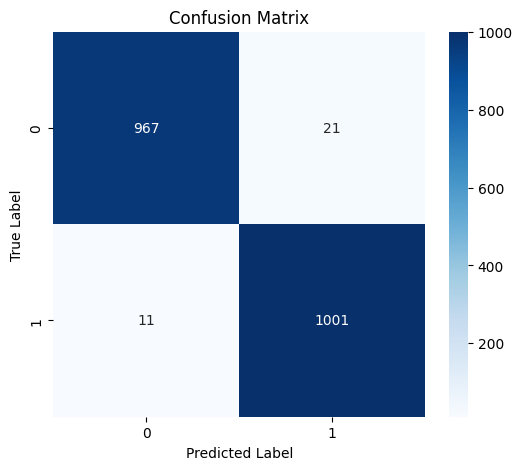

In [33]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()